In [1]:
import numpy as np
import pandas as pd

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")
from sklearn.linear_model import Ridge
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neural_network import MLPRegressor

import warnings
from scipy.linalg import LinAlgWarning
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV


In [2]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')


stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]
county_covid['county'] = county_covid['county'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Ignore LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'State'] = 'AZ'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'State'] = 'IL'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'State'] = 'MI'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'State'] = 'NV'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'State'] = 'MN'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'State'] = 'MA'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'State'] = 'LA'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'State'] = 'NJ'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'State'] = 'NJ'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'State'] = 'WA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'State'] = 'District of Columbia'
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'County(s)'] = 'District of Columbia'
stadium_county_df['County(s)'] = stadium_county_df['County(s)'].apply(lambda x: x.lower() if isinstance(x, str) else x)
stadium_county_df['Counties'] = stadium_county_df['Counties'].apply(lambda x: x.lower() if isinstance(x, str) else x)



In [11]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [12]:

#We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    #team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    if team_city_str in no_fans_list:
        #If no fans, there actually is NO stadium county, since they are *not* affected by opening stadium. 
        return ""
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'Kansas Chity':
            home_state = "MO"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NJ"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    buffer_counties = list(set(stadium_county_df.loc[(stadium_county_df['State.1'] == home_state)]['Counties'])) #List of neutral counties IN HOME STATE
    
    stadium_counties = list(set(stadium_county_df.loc[(stadium_county_df['State'] == home_state)]['County(s)'])) #List of Stadium counties
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations

    home_state = home_state_dict[home_state]
    
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]

    donor_counties = donor_counties.loc[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
    

    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team'].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team'].apply(find_donor_counties)
    
    
stadium_county_df['Stadium_Counties'] = stadium_county_df['Stadium_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])
stadium_county_df['Donor_Counties'] = stadium_county_df['Donor_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])


In [13]:
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8,Stadium_Counties,Donor_Counties
0,Arizona,10/25/2020,maricopa,AZ,NaN,NaN,NaN,NaN,NaN,[],"[yuma, apache, la paz, graham, coconino, pima,..."
1,Atlanta,10/25/2020,fulton,GA,18.63,cobb,GA,8.24,"April 12, 2020: Our database changed to exclud...","[nan, fulton]","[oglethorpe, whitfield, banks, newton, harris,..."
2,Atlanta,NaN,NaN,NaN,NaN,dekalb,GA,7.84,NaN,"[nan, fulton]","[oglethorpe, whitfield, banks, newton, harris,..."
3,Atlanta,NaN,NaN,NaN,NaN,gwinnett,GA,7.05,NaN,"[nan, fulton]","[oglethorpe, whitfield, banks, newton, harris,..."
4,Atlanta,NaN,NaN,NaN,NaN,hall,GA,2.49,NaN,"[nan, fulton]","[oglethorpe, whitfield, banks, newton, harris,..."
...,...,...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,warren,KY,1.23,NaN,"[nan, davidson, williamson]","[hickman, grundy, carter, cocke, houston, wash..."
181,Tennessee,NaN,NaN,NaN,NaN,knox,TN,1.17,NaN,"[nan, davidson, williamson]","[hickman, grundy, carter, cocke, houston, wash..."
182,Tennessee,NaN,NaN,NaN,NaN,cook,IL,1.01,NaN,"[nan, davidson, williamson]","[hickman, grundy, carter, cocke, houston, wash..."
183,Tennessee,NaN,NaN,NaN,NaN,cheatham,TN,1.01,NaN,"[nan, davidson, williamson]","[hickman, grundy, carter, cocke, houston, wash..."


In [236]:
#Make earlier process into a function to generalize to other Stadiums

Total_prediction_data_fans = []
Total_prediction_data_no_fans = []

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)

    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #CONVERT ALL OF THIS INTO A PIVOT TABLE FIRST
    
    ########
    
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] <= intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    num_pre_dates = X_train.shape[0]
    
    
    #Keep total X and Y data for future plots
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    assert total_X.shape[0] == total_Y.shape[0]
    
    
    ###########
    


    total_columns = X_train.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
    aggregate_errors = []
    r_squareds = []

    #U, S, V = np.linalg.svd(training_pivot, full_matrices=False)
    U, S, V = np.linalg.svd(X_train, full_matrices=False)
    
    for svalue in range(1,len(S)+1):
        

        singvals = svalue
        rscModel = RobustSyntheticControl(stadium_key, singvals, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
        rscModel.fit(training_pivot)
        
        denoisedDF = rscModel.model.denoisedDF()

        predictions = []
        predictions = np.dot(X_train, rscModel.model.weights) #Prediction fits pre-intervention
        
        assert predictions.shape[0] == num_pre_dates
        
        aggregate_y = Y_train # Actual Y cases 

        assert len(aggregate_y) == len(predictions)
        
        
        aggregate_error = np.linalg.norm(aggregate_y - predictions) / np.linalg.norm(aggregate_y)


        #Model is Training pivot


        
#         S_new = np.zeros_like(S)
#         S_new[:svalue] = S[:svalue]
#         S_new = np.diag(S_new)
        
#         reconstructed_pivot = U @ S_new @ V
        
#         aggregate_error = np.linalg.norm(reconstructed_pivot - training_pivot) / np.linalg.norm(training_pivot)
        
    
        aggregate_errors.append(aggregate_error)
    

        if (aggregate_error < 0.01):
            
            print(svalue)
            break
            
            
        if svalue == (len(S)):
            print("Uses all singular values initially")
            
            if min(aggregate_errors) < 0.015:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.015, aggregate_errors))[0]) + 1
                
            elif min(aggregate_errors) < 0.02:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.02, aggregate_errors))[0]) + 1
            else:
                svalue = len(S)
            print("Our final Kept singular value")
            print(svalue)
            break
        
        
    if team_name_str == 'San Francisco':
        svalue = 9
    elif team_name_str == 'Dallas':
        svalue = 31
    elif team_name_str == 'Washington':
        svalue = 4
        
        
    total_columns = total_X.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns



    rscModel = RobustSyntheticControl(stadium_key, svalue, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
    
    rscModel.fit(training_pivot)
    
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(total_X, rscModel.model.weights)

    #Following adds prediction data to construct historgram results T+days after intervention date
    if team_name_str in no_fans_list:
        Total_prediction_data_no_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                             predictions[num_pre_dates:num_pre_dates + 21])
    else:
        Total_prediction_data_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                          predictions[num_pre_dates:num_pre_dates + 21])
    
    assert predictions.shape[0] == total_Y.shape[0]
    
    if show_plot == True:

        #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
        fig, ax = plt.subplots()


        plt.plot(total_dates, total_Y, label = stadium_county_str)
        plt.plot(total_dates, predictions, label='Synthetic RBSC')
        
        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
        fig.autofmt_xdate()

        ax.legend()
        ax.xaxis_date()
        plt.show()
    else: #Below is for Synthetic Lines, which plots all six weeks onto the same plot. 
        true_intervention = intervention_date + datetime.timedelta(weeks=week)
        
        if week == -1: #Just return predictions, no plot. Used for RBSC when comparing with Bayesian Models
            return predictions
        elif week == 0:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'blue')
        else:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'grey')

        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")
        
        plt.tick_params(axis='x', which='major')
        plt.axvline(x=true_intervention, ymin = 0, ymax = 1, color='grey')

    return predictions


In [237]:
#Compute graphs for all combinations 

no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
Total_prediction_data_fans = []
Total_prediction_data_no_fans = []
dropped_stadium_df = stadium_county_df.copy()
dropped_stadium_df = dropped_stadium_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)


#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

Uses all singular values initially
Our final Kept singular value
5


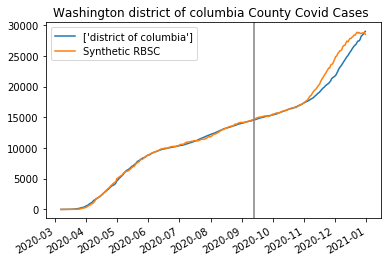

In [238]:
#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])


for i, (team, county, state, date) in enumerate(zipped_input):
    if (team == "Washington"):
        a = create_synthetic_graph(team, county, state, date, True, 0)
        

In [ ]:
#Make earlier function to be able to graph weeks 1-6 before the intervention. 
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']

def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    intervention_date = [x for x in intervention_date if x != ""]
    
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s
            
    intervention_date = pd.to_datetime(intervention_date)
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(0, 7)]
    print(team_name_str)
    count = 0
    for intervention in intervention_array: 
        
        intervention = intervention.strftime('%m/%d/%Y')
        l = []
        l.append(intervention)
        l.append("")
        
        create_synthetic_graph(team_name_str, stadium_county_str, state_str, l, False, count)
        
        count += 1
    plt.show()
    
    return 


In [ ]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['10/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):
    if team != "Washington":
        create_synthetic_lines(team, county, state, date)
        plt.show()


In [ ]:
#Create graphs for results after Game day. 

assert np.array(Total_prediction_data_no_fans).shape == (14, 21) #NUmber of teams, number of days past intervention
assert np.array(Total_prediction_data_fans).shape == (17, 21)

IQR_list = []

Time_series_no_fans = np.array(Total_prediction_data_no_fans).T #Transpose of time series data
Time_series_fans = np.array(Total_prediction_data_fans).T

# q1, q3 = np.percentile(Time_series, [25, 75], axis=1)
# iqr = q3 - q1

# print(q1)
# print(q3)

#plt.fill_betweenx(np.arange(len(iqr)), q1, q3, color='b', alpha=0.2)
fig, ax = plt.subplots()

plt.boxplot(Time_series_no_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top = 0.3)
plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with No Fans")
ax.axhline(0, color='grey', linestyle='--')

# Show the plot
plt.show()

fig,ax = plt.subplots()

plt.boxplot(Time_series_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top=0.3)

plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with Fans")
ax.axhline(0, color='grey', linestyle='--')
plt.show()
    

In [10]:
#MCMC Bayesian factor Synthetic Control

#Donors and Target. Key idea in Synthetic control is to learn some model to predict the values in target based on donors.

#Original method proves that you can caputre causal effects only if it's linear. 

#What we're trying to show is that a general model applies. 

#Draft that is a mess right now. 

#Stat 348. 

#Knowing Z gives me all the information about Y. 

#Probabilistic version of PCA

#Find a factor model, poisson factor. MCMC bayesian inference. 

#familiarize with PYRO, probabilistic programming framework. 

#Want to compute posterior given what you observe. Usually, the denominator you don't know how to compute. 

#So you have to approximate that integral. MCMC samples from the posterior. 

#Bayesian factor model generative story for the data, then gain back sample from the posterior. 

#Search through space of models efficiently, specify generative model and then get back posterior sample. 

#Alternative to PYRO is implementation, find alternative to probabilistic PCA and bayesian poisson factorization. 

#Probabilistic PCA bayesian, and poisson factorization samples of the posterior, apply it to dataset. 

#And then we will see how to check the models. 

#You are going to implement a function that can generate samples of data. Function represents hypothesis on how the dataset 
#Probabilistic generative for your data. Now give me a datset and I will sample from the posterior distribution from that data. 

In [153]:
grouped_df

,Team,First date home stadium open to fans,County(s),State
0,Arizona,[10/25/2020],[maricopa],[AZ]
1,Atlanta,"[10/25/2020, , , , , , , , , ]","[fulton, , , , , , , , , ]","[GA, , , , , , , , , ]"
2,Baltimore,"[11/1/2020, , , , , , , ]","[baltimore, baltimore city, , , , , , ]","[MD, MD, , , , , , ]"
3,Buffalo,"[Post season fans, First home, game no fans:, ...","[erie, , , , ]","[NY, , , , ]"
4,Carolina,"[10/4/2020, , , , , , , , ]","[mecklenburg, , , , , , , , ]","[NC, , , , , , , , ]"
5,Chicago,[9/20/2020],[cook],[IL]
6,Cincinnati,"[10/4/2020, , , , , , , , , , ]","[hamilton, , , , , , , , , , ]","[OH, , , , , , , , , , ]"
7,Cleveland,"[9/17/2020, , , , , , , , , ]","[cuyahoga, , , , , , , , , ]","[OH, , , , , , , , , ]"
8,Dallas,"[9/20/2020, , , , , , , , , ]","[dallas, tarrant, , , , , , , , ]","[TX, TX, , , , , , , , ]"
9,Denver,"[9/27/2020, , , , , , , , , , ]","[denver, arapahoe, , , , , , , , , ]","[CO, CO, , , , , , , , , ]"


In [ ]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.infer.mcmc as mcmc

#Below function gets training X and training Y data for applying Bayesian Model 
def get_training_data(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):

    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    print(intervention_date)
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)
    
    print(team_name_str)
    print(stadium_county_str)
    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    test_pivot = total_pivot.loc[total_pivot['date'] >= intervention_date]
    
    test_pivot = test_pivot.drop(['date'], axis=1)
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    test_X = test_pivot.loc[:, ~test_pivot.columns.isin(['Stadium_County'])]
    test_Y = test_pivot['Stadium_County']
    
    

    return X_train, Y_train, test_X, test_Y, total_dates

x_train, y_train, x_test, y_test, dates = get_training_data('Cincinnati',["Hamilton"] ,["OH"], ['10/04/2020'], True, 0)

dummy_train_x, dummy_train_y = torch.tensor(x_train.values), torch.tensor(y_train.values)

dummy_test_x, dummy_test_y = torch.tensor(x_test.values), torch.tensor(y_test.values)

dummy_train_x


In [18]:
#Import bayesian PCA

import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.infer.mcmc as mcmc

def bayesian_pca(data, latent_dim, mask): #Pass in mask directly into the model 
    # Define model parameters
    n, p = data.shape
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mu = torch.zeros(p)
    covariance = sigma * torch.eye(p)
    

#     Z_nl = pyro.sample("Z", dist.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim)).expand((n,)).to_event(1))
    
#     W_lp = pyro.sample("W", dist.MultivariateNormal(torch.zeros(p), torch.eye(p)).expand((latent_dim,)).to_event(1))
    
    Z_mean = pyro.param("Z_mean", torch.zeros(n, latent_dim))
    Z_cov = pyro.param("Z_cov", torch.eye(latent_dim))


    W_mean = pyro.param("W_mean", torch.zeros(latent_dim, p))
    W_cov = pyro.param("W_cov", torch.eye(p))
    
    
    Z_mean.data = torch.zeros(n, latent_dim)
    Z_cov.data = torch.eye(latent_dim)
    W_mean.data = torch.zeros(latent_dim, p)
    W_cov.data = torch.eye(p)

    Z_nl = pyro.sample("Z", dist.MultivariateNormal(Z_mean, Z_cov))
    W_lp = pyro.sample("W", dist.MultivariateNormal(W_mean, W_cov))
    
    mean = Z_nl @ W_lp

    # sample observed variables from a multivariate Gaussian with mean "mean" and covariance "covariance"
    
    #Implement mask on our data to avoid those probabilities. 

    X = pyro.sample("X", dist.Normal(mean, sigma).mask(mask), obs=data)
    
    
    return X


In [19]:
#dummy_train is what we are currently using to test our Bayesian Factor models. 

#Our PCA becomes 177 * 10, with last 30 * 3 Data to be masked. 

def bayesian_pca_mcmc(data, latent_dim, warmup_steps, num_samples):
    #data = torch.tensor(data.values)
    pyro.clear_param_store()   
    kernel = mcmc.NUTS(bayesian_pca)
    mcmc_run = mcmc.MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)

    N, P = data.shape
    mask_rows = torch.randperm(N)[:20]
    mask_cols = torch.randperm(P)[:5]

    mask = torch.ones(N,P)

    for i in mask_rows:
        for j in mask_cols:
            mask[i,j] = 0
    random_mask = mask.bool() #Boolean Tensor for mask

    end_block_mask = torch.ones(N,P)
    end_block_mask[-30:, -3:] = 0
    end_block_mask = end_block_mask.bool()


    test_mask = torch.ones(N,P)
    test_mask = test_mask.bool()

    #Apply MCMC to our data
    mcmc_run.run(data, latent_dim, random_mask)

    pyro.clear_param_store()
    #print(dummy_train)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract W, sigma, and Z samples
    W_samples = posterior_samples["W"]
    sigma_samples = posterior_samples["sigma"]
    Z_samples = posterior_samples["Z"]
    
    return W_samples, sigma_samples, Z_samples





In [20]:
N, P = dummy_train_x.shape
mask_rows = torch.randperm(N)[:20]
mask_cols = torch.randperm(P)[:5]

mask = torch.ones(N,P)

for i in mask_rows:
    for j in mask_cols:
        mask[i,j] = 0
random_mask = mask.bool() #Boolean Tensor for mask




In [21]:
####POISSON FACTORIZATION EXAMPLE

def poisson_factorization(data, latent_dim, mask):
    # Define model parameters
    n, p = data.shape
    
    #Construct samples of F, G, and X. X is assumed to be poisson distribution of F * G
    
#     alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
#     beta = pyro.sample("beta", dist.Gamma(1., 1.))
    F = pyro.sample("F", dist.Gamma(1, 1).expand([n, latent_dim]))
    G = pyro.sample("G", dist.Gamma(1, 1).expand([latent_dim, p]))
    

    #use our mask to mask data

    #Implement mask on our data to avoid those probabilities. 
#     with pyro.poutine.mask(mask=mask):
#         X = pyro.sample("X", dist.Poisson(F @ G), obs=data)x
    X = pyro.sample("X", dist.Poisson(F @ G).mask(mask), obs=data)
    
    return X

# Define model

def poisson_mcmc(training_data, latent_dim, warmup_steps, samples, mask_type="Random"): #Default masking type is Random
    #Runs MCMC on the poisson model, returns F and G Samples

    #training_data = torch.tensor(training_data.values)
    #Is our latent dimension here also deterined as a hyperparameter? 
    model = poisson_factorization


    #Create mask for training/testing purposes
    N, P = training_data.shape
    
    if mask_type == "Random":
        mask_rows = torch.randperm(N)[:20]
        mask_cols = torch.randperm(P)[:5]

        mask = torch.ones(N,P)

        for i in mask_rows:
            for j in mask_cols:
                mask[i,j] = 0

        mask = mask.bool() #Random column and rows mask
        
    elif mask_type == "End":

        #TEST END BLOCK MASK
        end_block_mask = torch.ones(N,P)
        end_block_mask[-30:, -3:] = 0
        mask = end_block_mask.bool()
        
    elif mask_type == "None":
        mask = torch.ones(N,P).bool()
    else:
        print("Invalid Mask")
        return

    # Run MCMC
    kernel = mcmc.NUTS(model)
    mcmc_run = mcmc.MCMC(kernel, num_samples=samples, warmup_steps=warmup_steps)

    #Run MCMC process on our data with given Latent dimension
    mcmc_run.run(training_data, latent_dim, mask)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract F, G, lambda_f, and lambda_g samples
    F_samples = posterior_samples["F"]
    G_samples = posterior_samples["G"]
    
    return F_samples, G_samples
    

In [196]:
#General Population Predictive Check function

def population_predictive_check(reconstructed_mean, mask, data, model, variance=None): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []

    for mean in reconstructed_mean:
        testing_mean = torch.tensor(mean[mask])
        
        if (model == 'Poisson'):
            sample_dist = dist.Poisson(testing_mean)
            
        elif (model == 'PCA'):
            sample_dist = dist.Normal(testing_mean, variance)
        
        else:
            print("Invalid model choice")
            return

        #Only have prediction on selected mask_rows and mask_cols
        y_pred  = sample_dist.sample()

        #Calculate the likelihood given this sample
        y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

        #Now, we want to calculate the likelihood of the actual data. 
        data_test = torch.tensor(data[mask])

        test_prob = sample_dist.log_prob(data_test).sum()

        log_prob.append(-1 * y_pred_likelihood) 
        test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    
    print(log_prob[:5])
    print(test_prob_list[:5])
    
    return percent_likelihood
    
    
#General Posterior Predictive Check Method(No Mask)

def posterior_predictive_check(reconstructed_mean, data, model, variance=None): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []
    print(reconstructed_mean.size())

    for mean in reconstructed_mean:
        if (model == 'Poisson'):
            sample_dist = dist.Poisson(mean)
            
        elif (model == 'PCA'):
            sample_dist = dist.Normal(mean, variance)
        
        else:
            print("Invalid model choice")
            return

        #Only have prediction on selected mask_rows and mask_cols
        y_pred = sample_dist.sample()

        #Calculate the likelihood given this sample
        y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

        #Now, we want to calculate the likelihood of the actual data. 
        data_test = torch.tensor(data)

        test_prob = sample_dist.log_prob(data_test).sum()

        log_prob.append(-1 * y_pred_likelihood) 
        test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    
    print(log_prob[-5:])
    print(test_prob_list[-5:])
    
    print(min(log_prob))
    print(min(test_prob_list))
    
    return percent_likelihood

    

In [175]:
#After posterior checks, aim to reconstruct Synthetic Control Method. 
from sklearn.linear_model import LinearRegression

def PCA_synthetic_control(W_samples, donor_train, stadium_train, donor_test, stadium_test, dates, team, RBSC, regression_type = 'Ridge', save_fig = False):
    #W_Samples should be size latent_dim * p
    
    #Z_samples size n * latent_dim
    #Donor_data should be size n*p 
    
    #Stadium_data should be size n*1
    
    #Our Y should be donor_test and stadium_test, so size should be post_intervention_t * p+1
    #Stadium_test is our Y, shape p by T
    
    synthetic_control_paths = []
    pre_intervention_days, counties = donor_train.shape
    post_intervention_days, counties = donor_test.shape

    latent_dim, w_counties = W_samples[0].shape
    
    #Store results for different synthetic control regressions, as we iterate through W_samples
    counterfactual_outcomes_deconfound = []
    time_step_outcomes = []
    
    for W_sample in W_samples: 
    
        #Run Regression with latent_p W_sample on Y_it, for each timestep t post intervention. 
        
        
        #Add [1] if it is intervention
        
        A = torch.zeros(w_counties)
        A[-1] = 1
        A = A.view(1, w_counties)

        x_regressors = torch.cat((W_sample, A), dim=0).transpose(0,1)
        
        assert x_regressors.shape == (w_counties, latent_dim + 1)

        #For Yit ~ Ai + Yi(-m) + … + Yi(-1), ,we need stadium data pre intervention, which is just stadium train

        #We want to fit donor_test and stadium_test together in one regression
        stadium_test = stadium_test.view(-1, 1)

        Y = torch.cat((donor_test, stadium_test), dim = 1)
        
        
        assert Y.shape == (post_intervention_days,  w_counties)
        
        #Ridge regression with alpha = 0.001 Works better
        #Try Ridge, Lasso, MLP Regression ,with Cross Validation to find best value. 
        
        #Parameters for GridsearchCV for Lasso and Ridge
        parameters = {"alpha": [0, 1e-4,1e-3, 1e-2]}
        if regression_type == 'Ridge':
            reg = linear_model.Ridge()
            clf = GridSearchCV(reg, parameters, scoring='r2', cv=5)
            
            deconfound_lin_reg = clf.fit(x_regressors, Y.transpose(0,1))
            deconfound_lin_reg = clf.best_estimator_
        elif regression_type == 'MLP': 
            clf = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
        elif regression_type == 'Lasso':
            reg = linear_model.Lasso(alpha = 0.01)
            #Right now 0.01 working best for lasso
            deconfound_lin_reg = reg.fit(x_regressors, Y.transpose(0, 1))
        
        counterfactual_x = x_regressors
        counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.
        
        if regression_type == 'MLP':
            counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
        elif regression_type in ['Ridge', 'Lasso']:
            coefficients = torch.tensor(deconfound_lin_reg.coef_)
        
            assert coefficients.shape[1] == latent_dim + 1
            assert coefficients.shape[0] == post_intervention_days


            #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
            #stadium county .

            counterfactual_outcome = counterfactual_x @ torch.tensor(coefficients).transpose(0,1)
        
        assert counterfactual_outcome.shape == Y.transpose(0,1).shape
        
        counterfactual_outcomes_deconfound.append(counterfactual_outcome)
        
        
        stadium_train = stadium_train.view(-1,1)

        
    
    if regression_type in ['Ridge', 'Lasso']:
        stadium_cf_deconfound = [counterfactuals[-1, :].numpy() for counterfactuals in counterfactual_outcomes_deconfound]
    else:
        stadium_cf_deconfound = [counterfactuals[-1, :] for counterfactuals in counterfactual_outcomes_deconfound]
    
    
    percentiles_5 = np.percentile(stadium_cf_deconfound, 5, axis=0)
    percentiles_95 = np.percentile(stadium_cf_deconfound, 95, axis=0)
    
    
    median_values = np.median(stadium_cf_deconfound, axis=0)
    post_dates = dates[-post_intervention_days:]
    plt.fill_between(post_dates, percentiles_5, percentiles_95, color='gray', alpha=0.3, label='5th-95th Percentile Range')
    pre_dates = dates[:pre_intervention_days]
    plt.plot(post_dates, median_values, label='Bayesian Synthetic Control Median Values ' + str(regression_type) + ' '+ str(team))
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='major')
    
    plt.plot(post_dates, stadium_test, label = 'Stadium Data Postintervention')
    plt.plot(pre_dates, stadium_train, label = 'Stadium Data Pre-intervention')
    plt.axvline(x=dates[pre_intervention_days], color='grey')

    
    plt.plot(dates, RBSC, label = 'Robust Synthetic Control')
    plt.title('Synthetic Control ' + str(team) + " with number of latents " + str(W_samples[0].shape[0]) + " and counties " + str(W_samples[0].shape[1]) +" and number of samples " + str(len(W_samples)))
    plt.legend()
    
    #Save plot figure
    if save_fig:
        plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
        plt.tight_layout() 
        folder = 'figures'
        file_name = f'{team}_g_samples.npy'

        save_name = f'{team}_plot.png'
        save_path = os.path.join(folder, save_name)
        plt.savefig(save_path)
    
    plt.show()

    
    
    return median_values

def Poisson_synthetic_control(F_samples, donor_train, stadium_train, donor_test, stadium_test, dates, team, RBSC, regression_type = 'Ridge', save_fig = False):
    #F_samples should have shape latent_dim * donors

    
    #Same thing as PCA synthetic control, except we use F_samples as deconfounding latents. 
    counterfactuals = PCA_synthetic_control(F_samples, donor_train, stadium_train, donor_test, stadium_test, dates, team, RBSC, regression_type, save_fig)
    
    return counterfactuals
    

#Setup linear regression, you can use multilayer perceptron. avoid regression on A

#You should also look at for each sample, the synthetic control process, AVERAGE LAST

#Sanity check, run placebo. Do this all in the pre-intervention, or let targets be other stadiums that didn't open.

#Factorize WITH targets. 

In [246]:
#Create dictionary for latent space dimensions for each team. 
latent_dim_dict = {'Arizona': 5, 'Atlanta':5 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinnati':13, 'Cleveland':14, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':8, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 8, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':10}


In [ ]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])


def bayesian_SC_graph(team_county_data):
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        count += 1

        #if team in ['Chicago','Tennessee', 'Detroit', 'Indianapolis']:  #Ignore Arizona
        if team in ['New Orleans']:  #Ignore Arizona
            #x are donors, y are stadiums, train is pre-intervention, test is post intervention

            x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

            x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)


            #Combine Donor and Stadium in our traning data
            synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)


            #Produce Confounder variable to use in our regression


            #PCA Process
    #         w_samples, sigma_samples, z_samples = bayesian_pca_mcmc(synthetic_control_training, 10, 500, 500)

    #         pca_p_value = posterior_predictive_check(z_samples@w_samples, synthetic_control_training, 'PCA', variance=sigma_samples[0])

    #         #With these samples, perform a POSTERIOR CHECK first, if it passes then we use that model. 

    #         pca_posterior_check = pca_p_value>=0

    #         if pca_posterior_check:
    #             deconfounders = PCA_synthetic_control(w_samples, x_train, y_train, x_test, y_test, dates, team)

            #Run Poisson Factorization Model



            latent_dimension = latent_dim_dict[team]

            f_samples, g_samples = poisson_mcmc(synthetic_control_training, latent_dimension, 1400,1400, "None")

            np.save(f'{team}_g_samples.npy', g_samples.numpy())
            np.save(f'{team}_f_samples.npy', f_samples.numpy())
            synthetic_control_training = synthetic_control_training.clamp(min=0)
            
            
            N,P = synthetic_control_training.shape
            end_block_mask = torch.ones(N,P)
            end_block_mask[-30:, -3:] = 0 #The mask size can be edited
            end_block_mask = end_block_mask.bool()

#             population_check = population_predictive_check(f_samples @ g_samples, end_block_mask, synthetic_control_training.round().to(torch.int64), 'Poisson')

        
            poisson_p_value = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')

            poisson_posterior_check = poisson_p_value >= 0

            RBSC_results = create_synthetic_graph(team, county, state, date, False, -1)

            if poisson_posterior_check:
                #Keep the g_samples

                deconfounders_ridge = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge', save_fig = False)
                #deconfounders_lasso = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Lasso')

                #Find results for robust synthetic control
    return 

bayesian_SC_graph(zipped_input)
        

['9/13/2020']
hi
New Orleans
['orleans']


Sample:  64%|██████▍   | 1787/2800 [1:28:50,  2.84s/it, step size=1.79e-03, acc. prob=0.822]

['10/25/2020']
hi
Atlanta
['fulton']
5


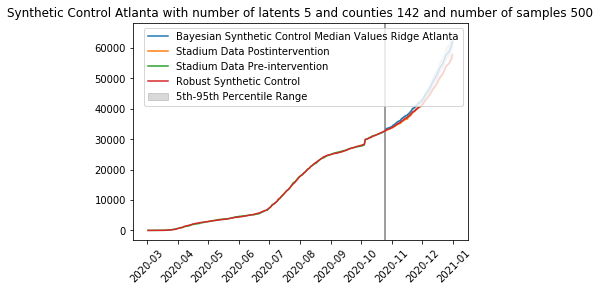

['11/1/2020']
hi
Baltimore
['baltimore', 'baltimore city']
5


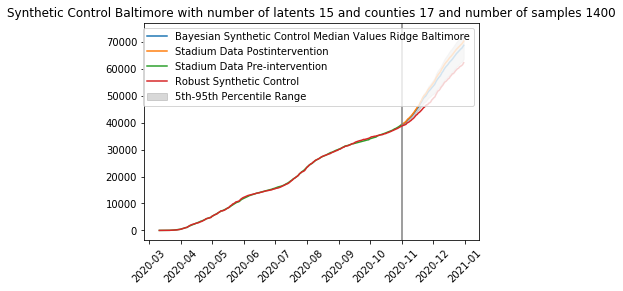

['Post season fans', 'First home', 'game no fans:', '9/13/2020']
hi
Buffalo
['erie']
10


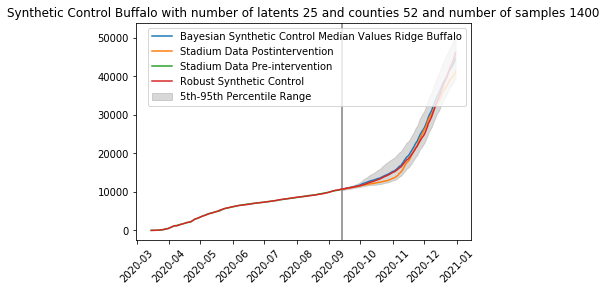

['10/4/2020']
hi
Carolina
['mecklenburg']
4


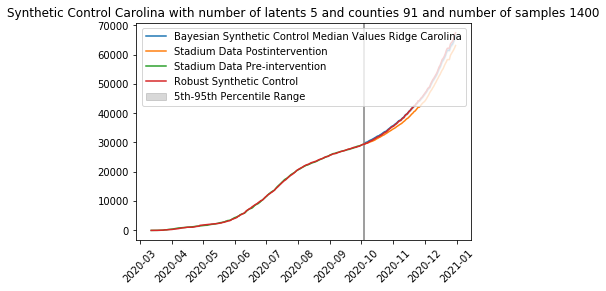

['9/20/2020']
hi
Chicago
['cook']
3


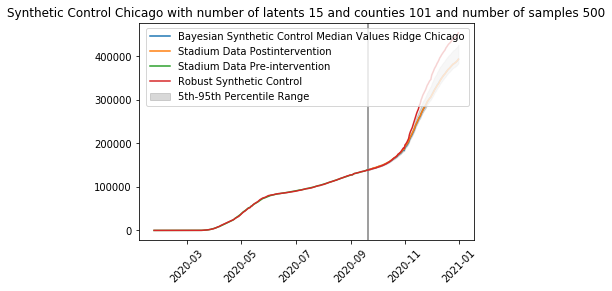

['10/4/2020']
hi
Cincinnati
['hamilton']
12


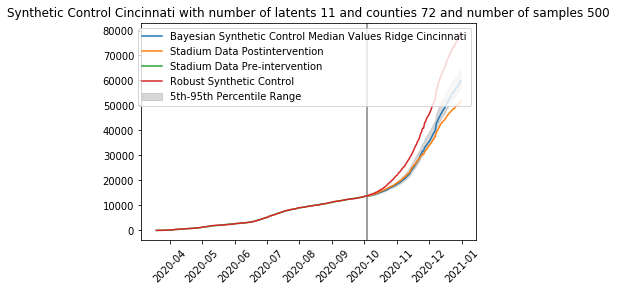

['9/17/2020']
hi
Cleveland
['cuyahoga']
15


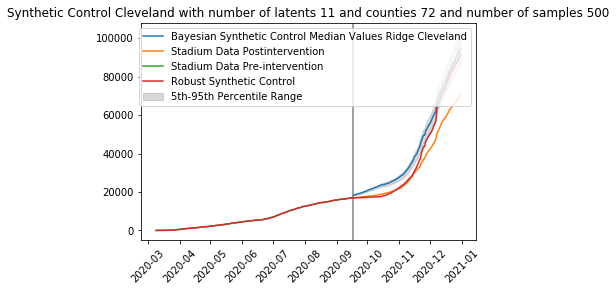

['9/20/2020']
hi
Dallas
['dallas', 'tarrant']
39


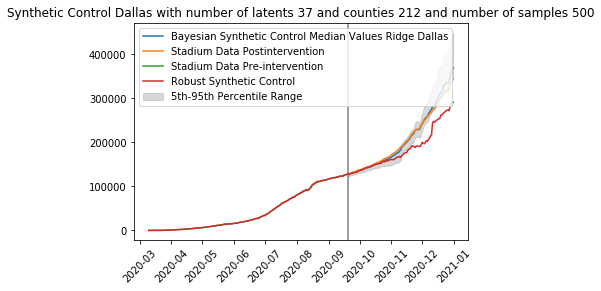

['9/27/2020']
hi
Denver
['denver', 'arapahoe']
6


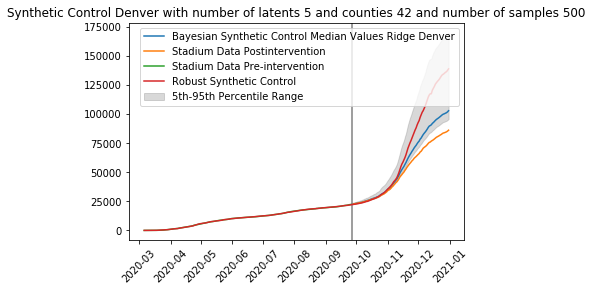

['9/13/2020']
hi
Detroit
['wayne']
14


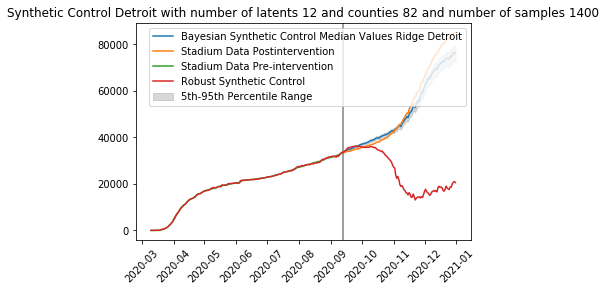

['Post season', 'First home', 'game no fans:', '9/20/2020']
hi
Green Bay
['brown']
Uses all singular values initially
Our final Kept singular value
14


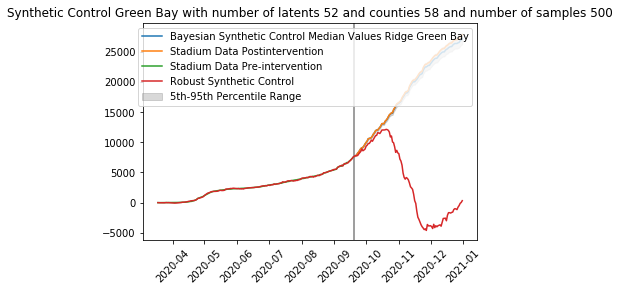

['10/4/2020']
hi
Houston
['harris']
12


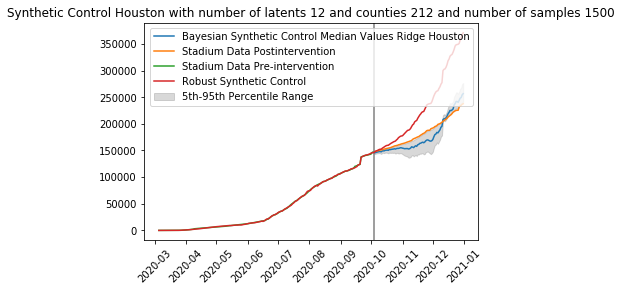

['9/20/2020']
hi
Indianapolis
['marion']
9


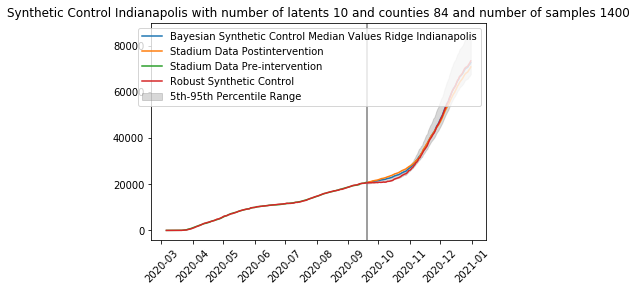

['9/13/2020']
hi
Jacksonville
['duval']
9


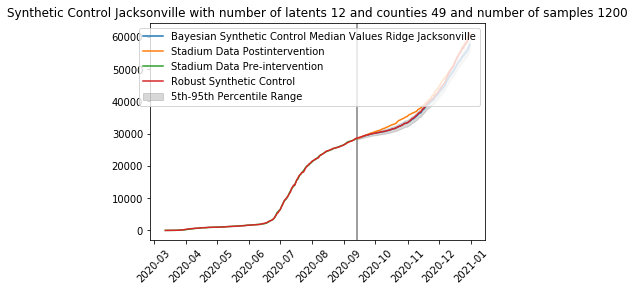

['9/10/2020']
hi
Kansas City
['johnson', 'jackson']
10


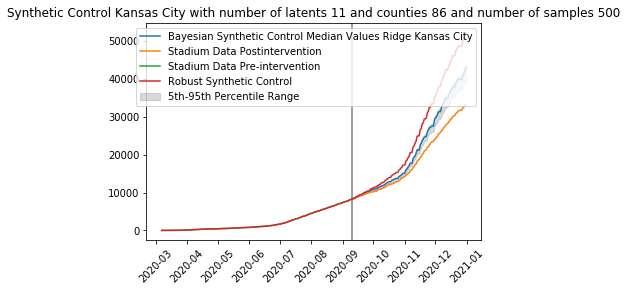

['9/13/2020']
hi
LA Chargers
['los angeles']
6


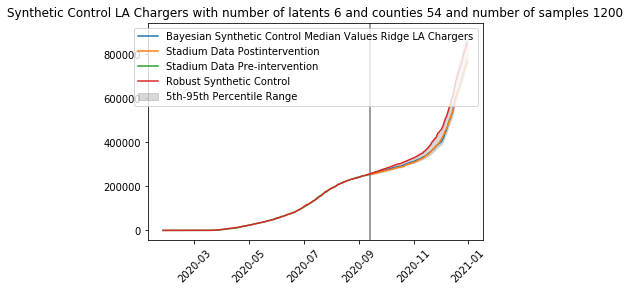

['9/13/2020']
hi
LA Rams
['los angeles']
6


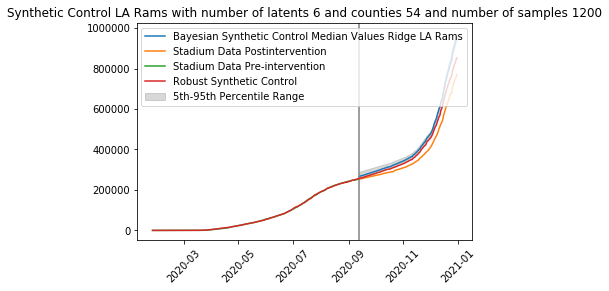

['9/21/2020']
hi
Las Vegas
['clark']
Uses all singular values initially
Our final Kept singular value
4


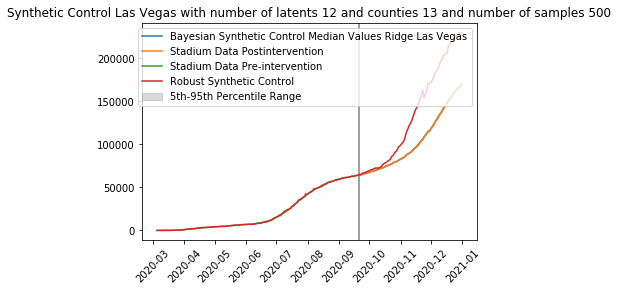

['9/20/2020']
hi
Miami
['broward', 'miami-dade', 'palm beach']
7


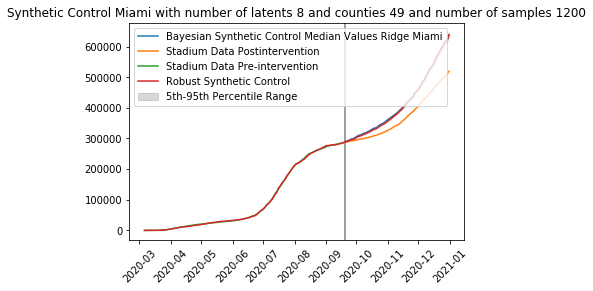

['9/13/2020']
hi
Minnesota
['ramsey']
6


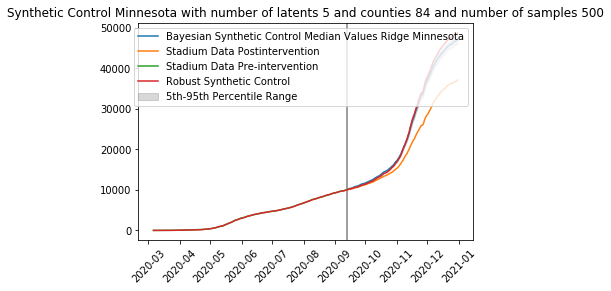

['9/14/2020']
hi
NY Giants
['bergen']
3


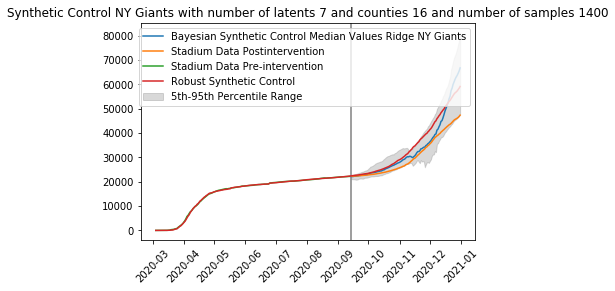

['9/14/2020']
hi
NY Jets
['bergen']
3


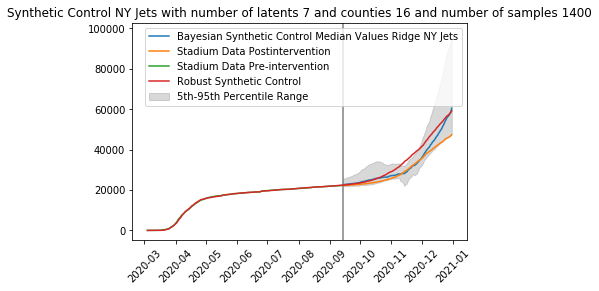

['9/13/2020']
hi
New England
['norfolk']
7


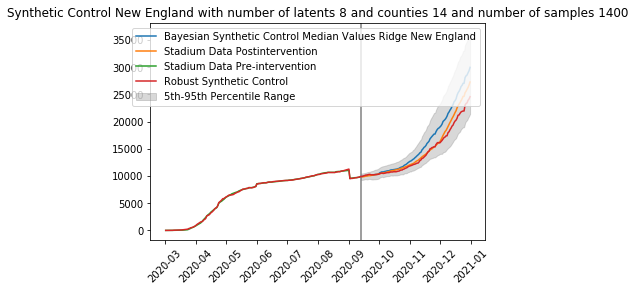

['9/13/2020']
hi
New Orleans
['orleans']
Uses all singular values initially
Our final Kept singular value
10


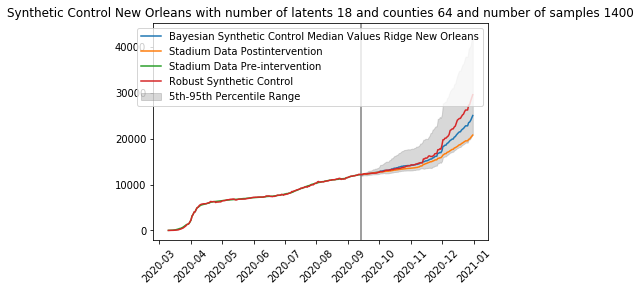

['10/18/2020']
hi
Philadelphia
['philadelphia']
8


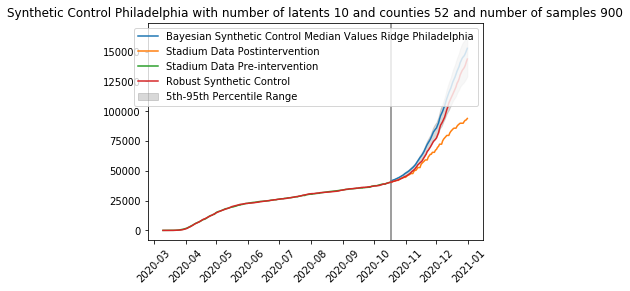

['10/11/2020']
hi
Pittsburgh
['allegheny']
23


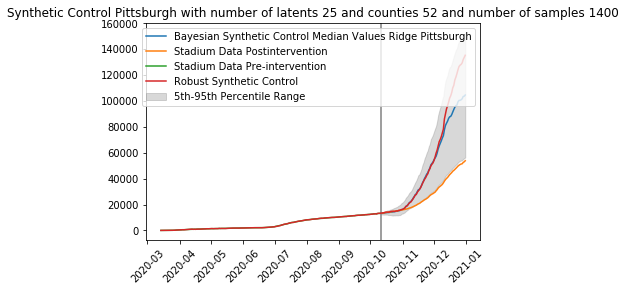

['9/13/2020']
hi
San Francisco
['santa clara']
Uses all singular values initially
Our final Kept singular value
12


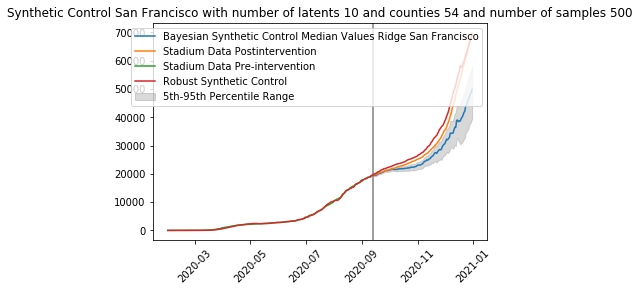

['9/20/2020']
hi
Seattle
['king']
Uses all singular values initially
Our final Kept singular value
5


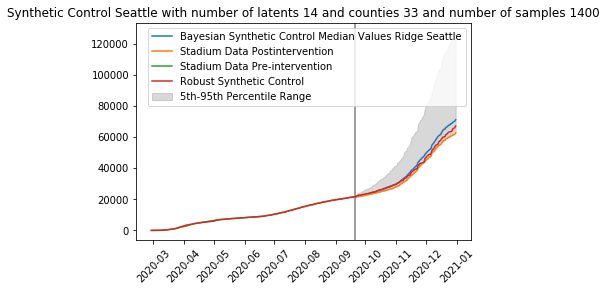

['10/4/2020']
hi
Tampa Bay
['hillsborough', 'pinellas']
8


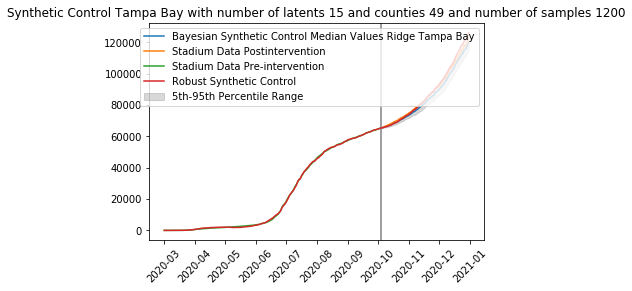

['9/13/2020']
hi
Tennessee
['davidson', 'williamson']
16


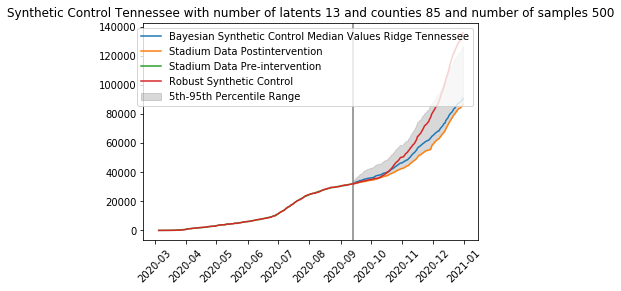

In [243]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

def bayesian_SC_graph_pre_loaded(team_county_data, calculate_ATT = False): #Difference is this function takes from pre-trained samples.
#We want to calculate ATT. 

    ATT_Bayesian_list = []
    ATT_RBSC_list = []
    
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        #if team in ['Cincinnati', 'Cleveland', 'Carolina', 'Atlanta', 'Denver', 'Kansas City', 'Minnesota', 'Philadelphia', 'Seattle', 'San Francisco', 'Tennessee']:
        if team != 'Arizona' and team != 'Washington': #Arizona data not included
            count += 1

            g_samples = torch.from_numpy(np.load(f'Trained_Samples/{team}_g_samples.npy'))
            #f_samples = torch.from_numpy(np.load(f'Trained_Samples/{team}_f_samples.npy'))

            x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

            x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)
            synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)
            synthetic_control_training = synthetic_control_training.clamp(min=0)

            synthetic_control_training = synthetic_control_training.clamp(min=0)
            RBSC_results = create_synthetic_graph(team, county, state, date, False, -1)

            deconfounders_ridge = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge', save_fig = False)
            #deconfounders_lasso = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Lasso')
            
            #post_check = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')
            
            if calculate_ATT:
                ATT_RBSC_list.append(RBSC_results[-len(y_test):] - y_test.numpy())
                ATT_Bayesian_list.append(deconfounders_ridge[-len(y_test):] - y_test.numpy())
    
    
    ####
    #ATT values should be subtracted from the actual values lol, not just added directly
    ###
    
    
    min_len = min(len(lst) for lst in ATT_RBSC_list)
    truncated_lists = [lst[:min_len] for lst in ATT_RBSC_list]
    RBSC_T= np.array(truncated_lists).T
    ATT_RBSC = np.mean(RBSC_T, axis=1)
    
    min_len = min(len(lst) for lst in ATT_Bayesian_list)
    truncated_lists = [lst[:min_len] for lst in ATT_Bayesian_list]
    Bayesian_transposed= np.array(truncated_lists).T
    ATT_Bayesian = np.mean(Bayesian_transposed, axis=1)
    
    return ATT_RBSC, ATT_Bayesian# ATT_Bayesian, ATT_RBSC
            
ATT_RBSC, ATT_Bayesian = bayesian_SC_graph_pre_loaded(zipped_input, True)


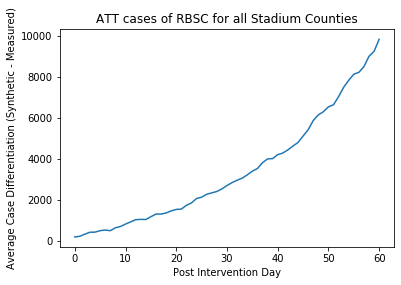

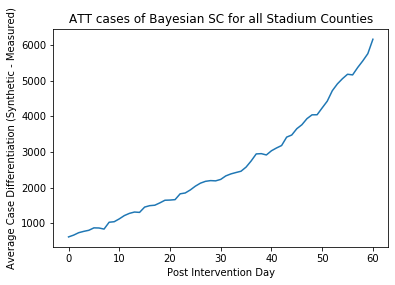

In [244]:
#GRAPH OUT ATT RESULTS 

post_intervention_days = range(len(ATT_RBSC))


plt.plot(post_intervention_days, ATT_RBSC)
plt.title("ATT cases of RBSC for all Stadium Counties")
plt.xlabel("Post Intervention Day")
plt.ylabel("Average Case Differentiation (Synthetic - Measured)")

plt.show()

post_intervention_days = range(len(ATT_Bayesian))

plt.plot(post_intervention_days, ATT_Bayesian)
plt.title("ATT cases of Bayesian SC for all Stadium Counties")
plt.xlabel("Post Intervention Day")
plt.ylabel("Average Case Differentiation (Synthetic - Measured)")

plt.show()

In [34]:
### POISSON GAMMA DYNAMICAL SYSTEMS ###

###Below DRaft, not actually used


def poisson_gamma_dynamical_system(data, latent_dim, mask=None):
    # Define model parameters
    n, p = data.shape
    time_steps = n
    G_matrix = []

    # Priors for latent states
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    beta = pyro.sample("beta", dist.Gamma(1., 1.))
    
    g_previous = pyro.sample("g_0", dist.Gamma(alpha, beta).expand([latent_dim]))

    #F should have shape latent * p 
    F_matrix = pyro.sample("F", dist.Gamma(1., 1.).expand([latent_dim, p]))
    
    G_matrix.append(g_previous)
    
    
    #K by K transition matrix
    concentration = torch.tensor([1] * latent_dim, dtype=torch.float)
    

    transition_matrix = pyro.sample("transition_matrix", dist.Dirichlet(concentration).expand([latent_dim]))#K by K matrix, Dirichlet Prior

    # Transition dynamics for the latent states
    
    # Transition dynamics for the latent states
    for t in pyro.markov(range(1, time_steps)):
        alpha_t = transition_matrix @ g_previous.T # previous
        
        g_t = pyro.sample(f"g_{t}", dist.Gamma(alpha_t, beta))
        G_matrix.append(g_t)

        # Update the previous state
        g_previous = g_t

    G_matrix = torch.stack(G_matrix, dim=0)
    
    if mask is None:
        mask = torch.ones(data.shape).bool()
    #Apply masking if necessary 
    X = pyro.sample("X", dist.Poisson(G_matrix @ F_matrix).mask(mask), obs=data)
    
    return X
    # Generate the observations
def poisson_gamma_mcmc(training_data, latent_dim, warmup_steps, samples, mask_type = None):
    
    model = poisson_gamma_dynamical_system
    
    N,P = training_data.shape
    
    kernel = mcmc.NUTS(model)
    
    pyro.clear_param_store()
    mcmc_run = mcmc.MCMC(kernel, num_samples = samples, warmup_steps = warmup_steps)
    
    mcmc_run.run(training_data, latent_dim)
    
    posterior_samples = mcmc_run.get_samples()
    
    F_samples = posterior_samples["F"]
    
    
    G_samples = [posterior_samples[f"g_{t}"].numpy() for t in range(N)]
    G_samples = np.stack(G_samples, axis=1)
        
    return G_samples, F_samples

In [31]:
#TEST PGDS 

zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

for i, (team, county, state, date) in enumerate(zipped_input):
    #if team in ['Cincinnati', 'Cleveland', 'Carolina', 'Atlanta', 'Denver', 'Kansas City', 'Minnesota', 'Philadelphia', 'Seattle', 'San Francisco', 'Tennessee']:
    if team in ['Cincinnati']:
        
        x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

        x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)
        synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)
        synthetic_control_training = synthetic_control_training.clamp(min=0)

        synthetic_control_training = synthetic_control_training.clamp(min=0)
        RBSC_results = create_synthetic_graph(team, county, state, date, False, -1)
        
        latent_dimension = latent_dim_dict[team]
        
        f_samples, g_samples = poisson_gamma_mcmc(synthetic_control_training, latent_dimension, 300, 300, "None")

        deconfounders_ridge = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge')


Cincinnati
['hamilton']
12


NameError: name 'poisson_gamma_mcmc' is not defined